# Dataset

In [1]:
import torch
# from torchvision import datasets, transforms
# import pycocotools
import matplotlib.pyplot as plt
import numpy as np
from step_2.datasets import COCOSegmentation

In [ ]:
# OLD
# def annToRLE(im, ann):
#     """
#     Convert annotation which can be polygons, uncompressed RLE to RLE.
#     :return: binary mask (numpy 2D array)
#     """
#     h, w = im.shape[2:]
#     print(h, w)
#     segm = ann['segmentation'][0]
#     print(segm)
#     if type(segm) == list:
#         # polygon -- a single object might consist of multiple parts
#         # we merge all parts into one mask rle code
#         rles = pycocotools.mask.frPyObjects(segm, h, w)
#         rle = pycocotools.mask.merge(rles)
#     elif type(segm['counts']) == list:
#         # uncompressed RLE
#         rle = pycocotools.mask.frPyObjects(segm, h, w)
#     else:
#         # rle
#         rle = ann['segmentation']
#     return rle

# def annToMask(im, ann):
#     """
#     Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
#     :return: binary mask (numpy 2D array)
#     """
#     rle = annToRLE(im, ann)
#     m = pycocotools.mask.decode(rle)
#     return m

In [2]:
dataDir='/mnt/Data/sa58728/coco-2017/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
dataset = COCOSegmentation(dataDir, 'val', crop_size=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

val set
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [ ]:
# OLD
# dataset = datasets.CocoDetection(root = dataDir + dataType,
#                                  annFile = annFile, 
#                                  transform = transforms.ToTensor(), 
#                                  target_transform = None,
#                                  transforms = None)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

In [4]:
i, l, n = dataset[0]
i.shape, l.shape, n

((427, 640, 3), torch.Size([427, 640]), '397133')

In [5]:
for (i, l, n) in dataloader:
    print(i.shape, l.shape, n)
    break

torch.Size([1, 427, 640, 3]) torch.Size([1, 427, 640]) ['397133']


In [6]:
# OLD
# for i, l in dataloader:
#     print(i.shape)
#     print(l[0].keys())
#     break

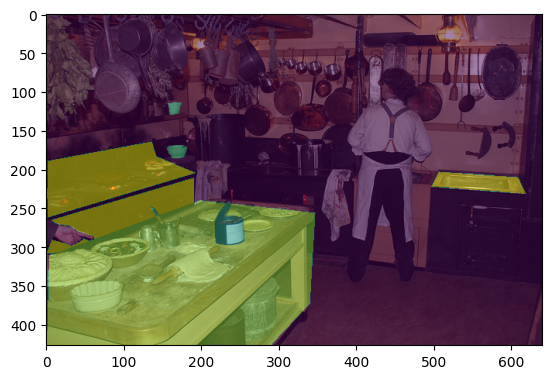

tensor([ 0,  1, 44, 49, 51, 67, 79, 81])

In [7]:
plt.imshow(i[0])
plt.imshow(l[0], alpha=0.5)
plt.show()
l.unique()

In [ ]:
# OLD

# Get binary mask from annotation
# plt.imshow(i[0].permute(1,2,0))
# m = np.zeros((i.shape[2], i.shape[3]))
# for p in l:
#     m += annToMask(i, p)
# plt.imshow(m, alpha=0.5)
# plt.show()

# Model

In [ ]:
import requests

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torch
from transformers import (SamModel, SamProcessor)

### Visualization Tools

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(6,6))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

### Load model

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

GPU = 3

device = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Sparse SAM
sparse = SamModel.from_pretrained("bin/90/").to(device).eval()

### Get Input Image

In [ ]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# plt.imshow(raw_image)
# plt.show()

### Run Inference with Prompt

In [ ]:
input_points = [[[450, 600]]]
# show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])


inputs.pop("pixel_values", None) # pixel_values are no more needed
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

### Decode Output

In [ ]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

In [ ]:
plt.imshow(masks.squeeze()[scores.argmax()])
plt.show()

# Outputs

In [ ]:
import random

In [ ]:
def get_output_masks(processor, model, i, input_points, device):
    inputs = processor(i, input_points=input_points, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    inputs.pop("pixel_values", None) # pixel_values are no more needed
    inputs.update({"image_embeddings": image_embeddings})
    with torch.no_grad():
        outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
    scores = outputs.iou_scores
    return masks, scores
    
def get_prompt(name, label):
    C = np.unique(label)[1:]
    c = np.random.choice(C)

    x_v, y_v = np.where(label == c)
    r = random.randint(0,len(x_v))
    x, y = x_v[r], y_v[r]
    return [[[y,x]]], c # inverted to compensate different indexing
    
# OLD
# def get_input_point(i, l):
#     # randomly pick an instance mask
#     m = random.sample(l, 1)[0]
#     c = m['category_id']
#     m = annToMask(i, m)
#     x_v, y_v = np.where(m >= 0)
#     r = random.randint(0,len(x_v))
#     x, y = x_v[r], y_v[r]
#     return [[[y,x]]], c

In [ ]:
def get_masks():

    name_list, mask_list, score_list, prompt_list, p_class_list = [], [], [], [], []
    for j, (i, l, n) in enumerate(dataloader):

        prompt, p_class = get_prompt(n, l[0])
        # show_points_on_image(i[0], input_points[0])

        masks, scores = get_output_masks(processor, model, i, prompt, device)
        # show_masks_on_image(i[0], masks, scores)  
        
        name_list.append(int(n[0]))
        mask_list.append(masks.squeeze()[scores.argmax()].cpu().detach().numpy())
        score_list.append(float(scores.max().cpu().detach().numpy()))
        prompt_list.append(prompt[0][0])
        p_class_list.append(int(p_class))

        if j > 10:
            break

    return name_list, prompt_list, p_class_list, mask_list, score_list

In [ ]:
name, prompt, p_class, mask, score = get_masks()

In [ ]:
i = 9
name[i], prompt[i], p_class[i], mask[i], score[i]

In [ ]:
plt.imshow(mask[i])
print(dataset.classes[p_class[i]])
print(name[i])

In [ ]:
Image.open('/mnt/Data/sa58728/coco-2017/val2017/' + str(name[i]).zfill(12) + '.jpg')

### Save DataFrame

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'name': name, 'prompt': prompt, 'class': p_class, 'mask': mask, 'score': score})

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.hist(column='class')

In [ ]:
df[['name', 'point', 'class']].to_pickle("results/coco_prompts.pkl")

In [ ]:
df[['name', 'point', 'class']]

In [ ]:
df = pd.read_pickle("results/cityscapes_prompts.pkl")

In [ ]:
df.head()

In [ ]:
df[df['name']==632][['point', 'class']].values[0][1]

### Predicted Classes

In [43]:
i = 1
image_true = dataset[i][0]
y_true = dataset[i][1]
y_pred = dataset[i][1]

In [44]:
def get_instance(label, c=None):
    if c is None:
        C = np.unique(label)[1:]
        c = np.random.choice(C)
        return label == c, c
    else:
        return label == c, c
    
def get_pred_classes(inst, label):
    return list(np.unique(inst * label))

sink


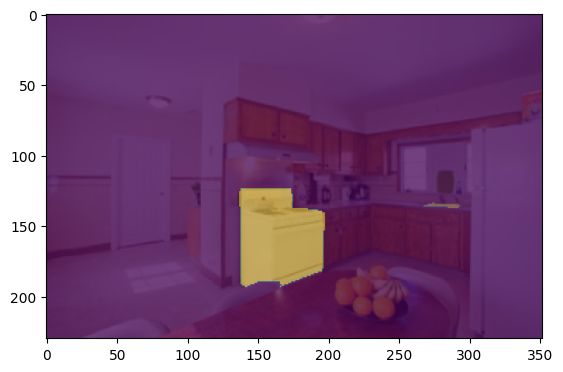

In [53]:
plt.imshow(image_true)

i_true, c_true = get_instance(y_true) # GT prompted instance label with associated class
plt.imshow(i_true, alpha=0.5)

i_pred, _ = get_instance(y_pred) # fake prompted instance label with associated class
plt.imshow(i_pred, alpha=0.5)

print(dataset.classes[c_true])

In [54]:
cl = get_pred_classes(i_pred, y_true) # mask, label
[dataset.classes[c] for c in cl]

['background', 'oven']

# Metrics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_pickle("results/coco_prompts.pkl")

In [ ]:
df.info()

In [ ]:
df_0 = pd.read_pickle("results/coco_SAM_0.pkl")
df_10 = pd.read_pickle("results/coco_SAM_10.pkl") 
df_50 = pd.read_pickle("results/coco_SAM_0.pkl") #
df_75 = pd.read_pickle("results/coco_SAM_75.pkl")
df_80 = pd.read_pickle("results/coco_SAM_80.pkl")
df_90 = pd.read_pickle("results/coco_SAM_90.pkl")

In [ ]:
def calculate_metrics(target, pred, eps=1e-5, verbose=False):

    if verbose:
        plt.subplot(1, 2, 1)
        plt.imshow(target)
        plt.subplot(1, 2, 2)
        plt.imshow(pred)
        plt.show()

    output = np.reshape(pred, -1)
    target = np.reshape(target, -1)

    tp = np.sum(output * target)  # TP (Intersection)
    un = np.sum(output + target)  # Union
    fp = np.sum(output * (~target))  # FP
    fn = np.sum((~output) * target)  # FN
    tn = np.sum((~output) * (~target))  # TN

    iou = (tp + eps) / (un + eps)
    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)

    if verbose:
        print(f"IoU: {iou:.4f}, Pixel Acc: {pixel_acc:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")

    return iou, pixel_acc, dice, precision, specificity, recall

In [ ]:
idx = 2
s_0 = df_0.iloc[idx]
s_50 = df_50.iloc[idx]

c = s_0['class']
print(f"Class: {dataset.classes[c]} [{c}]")
print(f"Prompt: {s_0['prompt']}")

print(f"Score: {s_0['score']:.4f}, {s_50['score']:.4f}")

i, a, d, p, r, s = calculate_metrics(s_0['mask'], s_50['mask'], verbose=True)
print(f"Name: {s_0['name']}")


In [ ]:
for j, (i, l, n) in enumerate(dataloader):
    if j == idx:
        break

In [ ]:
show_points_on_image(l[0], [[s_0['prompt'][0], s_0['prompt'][1]]])
show_points_on_image(i[0], [[s_0['prompt'][0], s_0['prompt'][1]]])
show_points_on_image(s_0['mask'], [[s_0['prompt'][0], s_0['prompt'][1]]])

l[0][s_0['prompt'][1], s_0['prompt'][0]]

In [ ]:
def get_analytics(target_df, pred_df):
    metrics = {k: [] for k in ['name', 'prompt', 'class', 'score', 'score_diff', 'mask_size', 'mask_size_diff',  'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']}
    for i in range(len(target_df)):
        target = target_df.loc[i]
        pred = pred_df.loc[i]

        iou, pixel_acc, dice, precision, specificity, recall = calculate_metrics(target['mask'], pred['mask'])
        
        metrics['name'].append(target['name'])
        metrics['prompt'].append(target['prompt'])
        metrics['class'].append(target['class'])
        metrics['score'].append(pred['score'])
        metrics['score_diff'].append((pred['score'] - target['score']) / (target['score'] + 1e-5))
        p_size = np.mean(pred['mask'].astype('float'))
        t_size = np.mean(target['mask'].astype('float'))
        metrics['mask_size'].append(p_size)
        metrics['mask_size_diff'].append((p_size - t_size) / (t_size + 1e-3))
        metrics['iou'].append(iou)
        metrics['pixel_acc'].append(pixel_acc)
        metrics['dice'].append(dice)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
    
    return pd.DataFrame(metrics)

In [ ]:
df = get_analytics(df_0, df_90)

In [ ]:
df.head()

In [ ]:
for k in ['class', 'score', 'score_diff', 'mask_size', 'mask_size_diff',  'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']:
    s = pd.Series(df[k])
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    n, bins, patches = ax.hist(s, bins='auto')
    n, bins, patches = ax2.hist(s, cumulative=True, histtype='step', bins='auto', color='tab:orange', linewidth=2, density=True)
    plt.title(k)
    plt.show()